<a href="https://colab.research.google.com/github/cleb98/ML-DL_lab/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [ ]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2025-07-06 15:28:35--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2025-07-06 15:28:35 (51.0 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



## Library

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

In [36]:
training_set = pd.read_csv('airline-passengers.csv')
training_set.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [37]:
training_set.columns

Index(['Month', 'Passengers'], dtype='object')

In [38]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values
len(training_set)

144

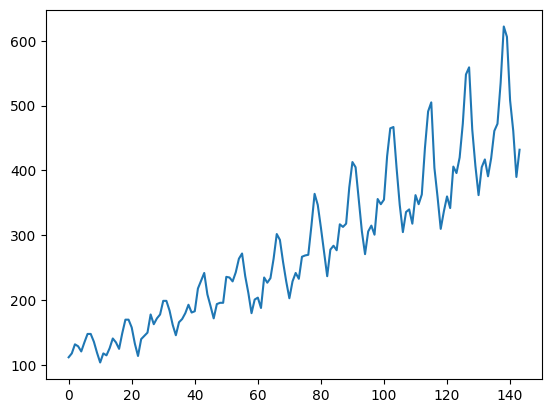

In [39]:
#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Dataloading

In [40]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        if i == 0:
           print(f'sequence_{i} = {_x}')
           print(f'target_{i} = {_y}')
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [41]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)
print(f'dataset lenght: ', len(training_data))
seq_length = 4
x, y = sliding_windows(training_data, seq_length)
print(x.shape)
print(y.shape)

dataset lenght:  144
sequence_0 = [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]]
target_0 = [0.03281853]
(139, 4, 1)
(139, 1)


In [42]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

In [43]:
trainX[0]

tensor([[0.0154],
        [0.0270],
        [0.0541],
        [0.0483]])

In [44]:
trainY[0]

tensor([0.0328])

## Model

In [62]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # print(f'input is: {x.shape}\n')
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)

        # print(f'hidden state: {h_0.shape}\n')

        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        # print(f'cell state: {c_0.shape}\n')

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # print(f'ula that is ignored: {ula.shape}\n')
        # print(f'h_out: {h_out.shape}\n')

        h_out = h_out.view(-1, self.hidden_size)
        # print(f'h_out before fc: ', h_out.shape)

        out = self.fc(h_out)
        # print(f'out: {out.shape}\n')


        return out

In [71]:
class LSTMAP(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTMAP, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.attn_layer = nn.Linear(hidden_size, 1)


        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # print(f'input is: {x.shape}\n')
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)

        # print(f'hidden state: {h_0.shape}\n')

        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        # print(f'cell state: {c_0.shape}\n')

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # print(f'ula that is ignored: {ula.shape}\n')
        # print(f'h_out: {h_out.shape}\n')

        # calcola scores per ogni timestep
        attn_scores = self.attn_layer(ula)           # shape [batch, seq_len, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)

        # applica i pesi agli hidden states
        ula_weighted = ula * attn_weights
        ula_sum = torch.sum(ula_weighted, dim=1)

        out = self.fc(ula_sum)



        return out

In [81]:
class LSTMAP_DotAttention(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTMAP_DotAttention, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))  # ula: [batch, seq_len, hidden_size]

        # ultimo hidden state → query
        query = h_out[-1]                           # [batch, hidden_size]
        query = query.unsqueeze(1)                  # [batch, 1, hidden_size]

        # dot product
        scores = torch.bmm(ula, query.transpose(1, 2))   # [batch, seq_len, 1]

        attn_weights = torch.softmax(scores, dim=1)      # [batch, seq_len, 1]

        ula_weighted = ula * attn_weights
        context = torch.sum(ula_weighted, dim=1)         # [batch, hidden_size]

        out = self.fc(context)
        return out


In [77]:
input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm

LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [54]:
# lstm.eval()
# train_predict = lstm(dataX)

input is: torch.Size([139, 4, 1])

hidden state: torch.Size([1, 139, 2])

cell state: torch.Size([1, 139, 2])

ula that is ignored: torch.Size([139, 4, 2])

h_out: torch.Size([1, 139, 2])

h_out before fc:  torch.Size([139, 2])
out: torch.Size([139, 1])



In [72]:
input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTMAP(num_classes, input_size, hidden_size, num_layers)
lstm

LSTMAP(
  (attn_layer): Linear(in_features=2, out_features=1, bias=True)
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [73]:
lstm.eval()
train_predict = lstm(dataX)
train_predict[0]

tensor([0.3057], grad_fn=<SelectBackward0>)

In [83]:
input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTMAP_DotAttention(num_classes, input_size, hidden_size, num_layers)
lstm

LSTMAP_DotAttention(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [84]:
lstm.eval()
train_predict = lstm(dataX)
train_predict[0]

tensor([-0.1466], grad_fn=<SelectBackward0>)

## Training

- fai il training prima con lstm = LSTM;

- poi rifallo con lstm = LSTMAP

- ci sono due celle oer calcolar euna volta MSE(LSTM) e poi MSE(LSTMAP)
- si vederà comel'aggointa del layer di attenzione migliora di brutto le performance di mapping;

In [85]:
num_epochs = 2000
learning_rate = 0.01

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.15334
Epoch: 100, loss: 0.01512
Epoch: 200, loss: 0.00572
Epoch: 300, loss: 0.00467
Epoch: 400, loss: 0.00449
Epoch: 500, loss: 0.00432
Epoch: 600, loss: 0.00413
Epoch: 700, loss: 0.00393
Epoch: 800, loss: 0.00370
Epoch: 900, loss: 0.00344
Epoch: 1000, loss: 0.00308
Epoch: 1100, loss: 0.00245
Epoch: 1200, loss: 0.00197
Epoch: 1300, loss: 0.00167
Epoch: 1400, loss: 0.00159
Epoch: 1500, loss: 0.00155
Epoch: 1600, loss: 0.00153
Epoch: 1700, loss: 0.00151
Epoch: 1800, loss: 0.00150
Epoch: 1900, loss: 0.00149


## Testing for Airplane Passengers Dataset

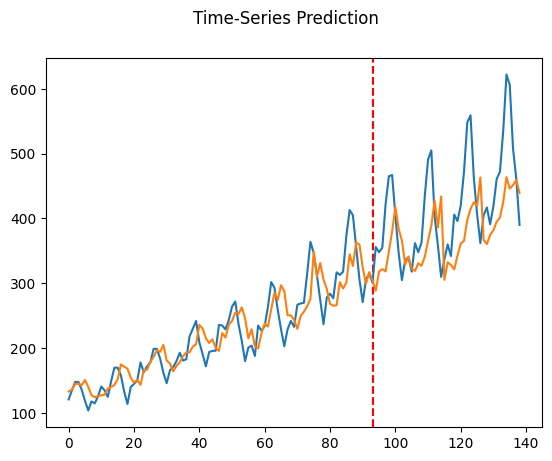

MSE:  2614.516845703125


In [79]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

#compute mse between data_predict e dataY:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(dataY_plot, data_predict)
print('MSE LSTM: ', mse)

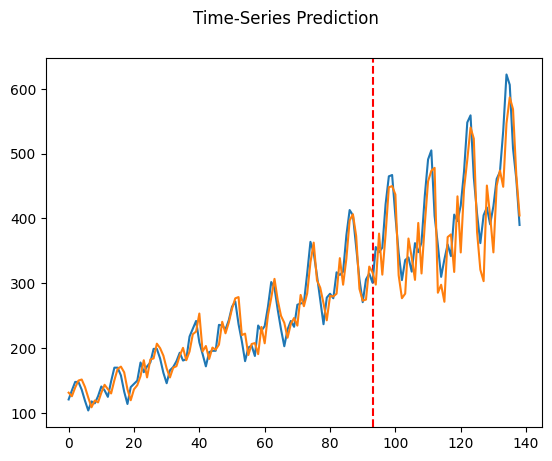

MSE:  994.215576171875


In [76]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

#compute mse between data_predict e dataY:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(dataY_plot, data_predict)
print('MSE LSTMAP: ', mse)


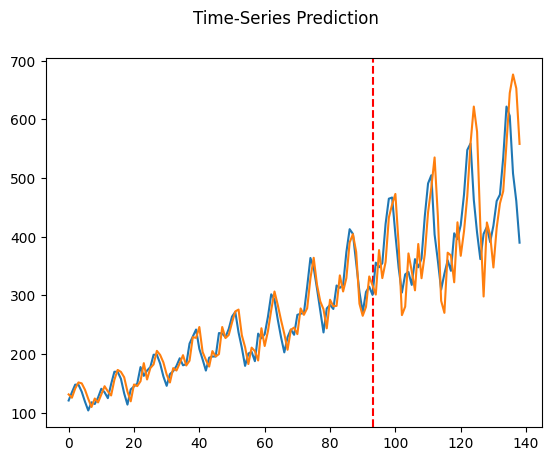

MSE:  2163.84423828125


In [86]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

#compute mse between data_predict e dataY:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(dataY_plot, data_predict)
print('MSE_dot_product: ', mse)
